In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 48.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms

import timm
import tqdm

In [4]:
if not os.path.exists('/content/A6'):
    os.makedirs('/content/A6')

In [5]:
!unzip -qq /content/drive/MyDrive/CV_project/data/SKIN/disease/A6.zip -d /content/A6

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
!nvidia-smi

Fri May 31 07:17:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              14W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Load Data

In [8]:
batch_size = 64
img_size = 224
model_type = 'A6'

data_dir = '/content/A6'

In [9]:
for folder in os.listdir(data_dir):
    print(folder, len(os.listdir(os.path.join(data_dir, folder))))

normal 12840
disease 12840


In [10]:
from torchvision.transforms import (
    Compose,
    ToTensor,
    Normalize
)

# dataset = datasets.ImageFolder(data_dir, ToTensor())

In [ ]:
def get_norm_std(dataset):
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for inputs, _ in dataset:
        for i in range(3):
            mean[i] += inputs[i,:,:].mean()
            std[i] += inputs[i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))

    return mean, std

In [ ]:
# mean_, std_ = get_norm_std(dataset)
# print(mean_, std_)

In [ ]:
# All dataset
# mean_ = (0.5589, 0.5298, 0.5114)
# std_ = (0.2119, 0.2031, 0.2015)

# imageNet
# mean_ = (0.485, 0.456, 0.406)
# std = (0.229, 0.224, 0.225)

# A6
mean_ = (0.5589, 0.5292, 0.5101)
std_ = (0.1868, 0.1859, 0.1854)

In [11]:
transforms = Compose(
        [
            ToTensor(),
            # Normalize(mean_, std_)
        ]
    )

In [12]:
dataset = datasets.ImageFolder(data_dir, transforms)

In [ ]:
# train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms)
# valid_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transforms)
# test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms)

In [13]:
torch.manual_seed(42)

train_size = int(len(dataset)*0.8)
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
labels = dataset.classes
num_classes = len(labels)
labels

['disease', 'normal']

In [14]:
print(len(train_dataset), len(valid_dataset))

20544 5136


In [15]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          pin_memory=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          pin_memory=True)

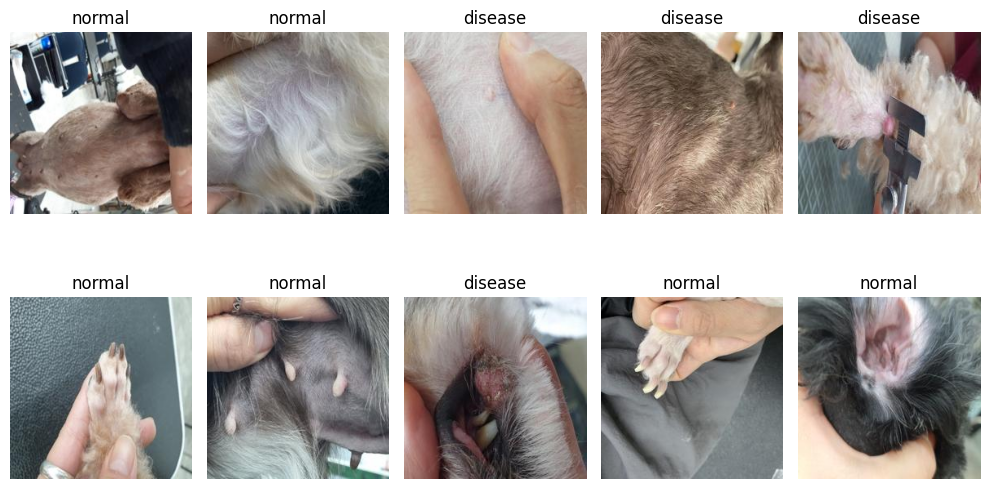

In [16]:
valid_10 = [valid_dataset[i] for i in random.sample(list(range(0, len(valid_dataset))), 10)]

fig, ax = plt.subplots(2, 5, figsize=(10, 6), tight_layout=True)

for i in range(2):
    for j in range(5):
        img = valid_10[(i*5)+j][0]
        img = img.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)
        ax[i][j].imshow(img)
        ax[i][j].set_title(labels[valid_10[(i*5)+j][1]])
        ax[i][j].axis('off')

plt.show()

# Model Training

In [ ]:
# inception_v4 1536
# inception_resnet_v2 1536
# resnet50 2048
# resnetv2_50 2048
# efficientnet_b0 1280
# vit_base_patch16_224 768
# vit_base_patch8_224 768
# vit_base_resnet26d_224 768
# vit_base_resnet50d_224 768
# vit_small_resnet26d_224 768
# vit_small_resnet50d_s16_224 768

In [17]:
model_name = 'efficientnet_b0'
hidden_size = 640
pretrained = True
model = timm.create_model(model_name, pretrained=pretrained, num_classes=hidden_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
# for i, (name, param) in enumerate(model.named_parameters()):
#     print(i, name)

In [ ]:
# if pretrained:
#     for i, (name, param) in enumerate(model.named_parameters()):
#         if 'head' in name:
#           print(i, name)
#           break

#         param.requires_grad = False

In [18]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [19]:
from IPython.display import clear_output

def loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch):

  figure, ax = plt.subplots(1, 2, figsize=(12, 5))

  ax[0].plot(train_loss_epoch)
  ax[0].plot(val_loss_epoch)
  ax[0].set_title('Loss-Epoch curve')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['train', 'val'], loc='upper right')

  ax[1].plot(train_acc_epoch)
  ax[1].plot(val_acc_epoch)
  ax[1].set_title('Model Accuracy')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['train', 'val'], loc='lower right')

  plt.show()

In [20]:
class Classifier(nn.Module):
    def __init__(self, model, hidden_size, num_classes=2):
        super().__init__()
        self.model = model
        self.classifier = nn.Linear(hidden_size, num_classes)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x # self.sigmoid(x)

In [21]:
classifier = Classifier(model, hidden_size, num_classes=num_classes).to(device)
# classifier = model.to(device)

In [22]:
opt_name = 'Adam'
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001) # correct_bias=False # Adam
# optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.001, weight_decay=0.0005)
# optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, weight_decay=1e-5, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                         factor=0.5, patience=2)
loss_fn = nn.CrossEntropyLoss()

In [23]:
from collections import OrderedDict
import pickle

def save_checkpoint(epoch, labels, model, optimizer, lr_scheduler,
                    train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                    model_path, filename):

    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'label': labels
    }
    torch.save(state, os.path.join(model_path, f'{filename}.pt'))

    config = {"train":{"acc":train_acc_epoch, "loss":train_loss_epoch},
          "valid":{"acc":val_acc_epoch, "loss":val_loss_epoch}}

    with open(os.path.join(model_path, f'{filename}.pickle'),'wb') as fw:
        pickle.dump(config, fw)

In [24]:
model_path = f'/content/drive/MyDrive/CV_project/skin_model/{model_type}'
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [25]:
def load_dict(model, optimizer, lr_scheduler, dict_file):

    pretrained = torch.load(dict_file)

    epoch = pretrained['epoch']
    state_dict = pretrained['state_dict']
    opt_dict = pretrained['optimizer']
    sch_dict = pretrained['lr_scheduler']
    labels = pretrained['label']

    model_dict = model.state_dict()
    model_dict.update(state_dict)
    model.load_state_dict(model_dict)

    optimizer.load_state_dict(opt_dict)
    lr_scheduler.load_state_dict(sch_dict)

    return epoch, labels, model, optimizer, lr_scheduler

In [26]:
import pickle
def load_records(pkl_file):
    with open(pkl_file, 'rb') as f:
        records = pickle.load(f)
    return records['train'], records['valid']

In [27]:
file_path = model_path

pretrained = False

In [28]:
num_epochs = 10

best_val_acc, best_val_loss = 0.0, 100.0

train_loss_epoch, val_loss_epoch = [], []
train_acc_epoch, val_acc_epoch = [], []
lr_epoch = []
epoch_start = 0

classifier = classifier.to(device)

if pretrained:
    dict_file = os.path.join(file_path, f'{model_name}_{opt_name}.pt')
    pkl_file = os.path.join(file_path, f'{model_name}_{opt_name}.pickle')

    epoch_start, labels, model, optimizer, lr_scheduler = load_dict(classifier, optimizer, lr_scheduler, dict_file)
    train_epoch, valid_epoch = load_records(pkl_file)
    train_loss_epoch, train_acc_epoch = train_epoch['loss'], train_epoch['acc']
    val_loss_epoch, val_acc_epoch = valid_epoch['loss'], valid_epoch['acc']
    best_val_acc, best_val_loss = max(val_acc_epoch), min(val_loss_epoch)

In [29]:
print(epoch_start, best_val_acc, best_val_loss)

0 0.0 100.0


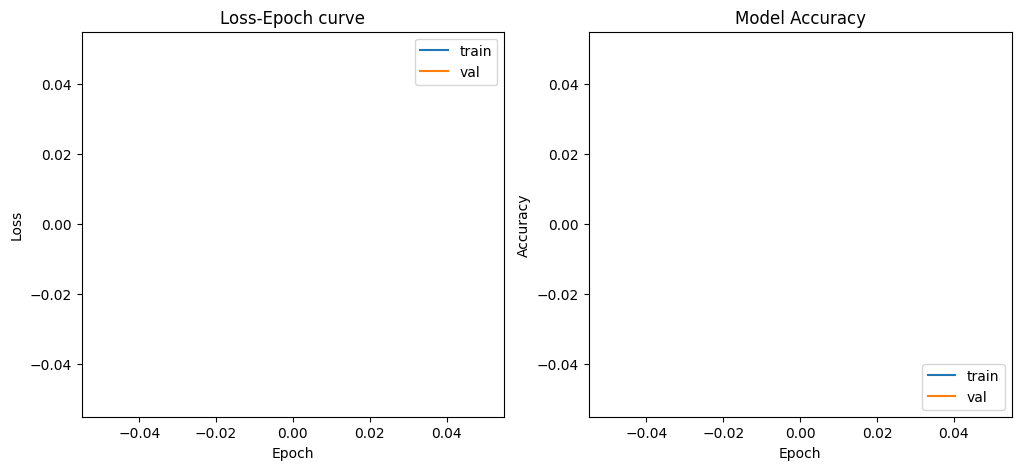

In [30]:
loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)

In [ ]:
epoch_start = e

epoch 8 train acc 0.995132398753894 validation acc 0.9650848765432098


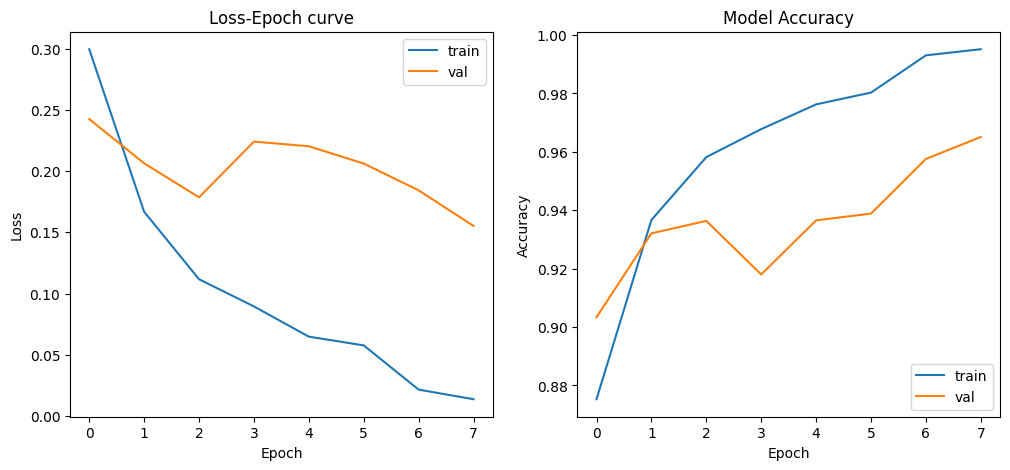

  0%|          | 0/321 [00:00<?, ?it/s]

epoch 9 train acc 0.995813862928349 loss 0.011894725742085287 lr 0.0005


  0%|          | 0/81 [00:00<?, ?it/s]

epoch 9 valid acc 0.9637345679012346 loss 0.18843957176432014


  0%|          | 0/321 [00:00<?, ?it/s]

epoch 10 train acc 0.9953757788161994 loss 0.01318639013010046 lr 0.0005


  0%|          | 0/81 [00:00<?, ?it/s]

epoch 10 valid acc 0.964891975308642 loss 0.17818905624423037


In [31]:
for e in range(epoch_start+1, num_epochs+epoch_start+1):
    train_acc, train_loss = 0.0, 0.0
    val_acc, val_loss = 0.0, 0.0
    classifier.train()
    for batch_id, batch in enumerate(tqdm.notebook.tqdm(train_loader)):
        optimizer.zero_grad()

        img = batch[0].to(device)
        label = batch[1].to(device) # .squeeze(1) .float()

        out = classifier(img).squeeze(1)
        loss = loss_fn(out, label)

        train_loss += loss.item()
        loss.backward()

        optimizer.step()

        train_acc += calc_accuracy(out, label)

    tot_train_acc = train_acc / (batch_id+1)
    mean_train_loss = train_loss / (batch_id+1)
    train_loss_epoch.append(mean_train_loss)
    train_acc_epoch.append(tot_train_acc)
    lr = optimizer.param_groups[0]['lr']
    lr_epoch.append(lr)
    print("epoch {} train acc {} loss {} lr {}".format(e, tot_train_acc, mean_train_loss, lr))

    classifier.eval()
    with torch.no_grad():
        for batch_id, batch in enumerate(tqdm.notebook.tqdm(valid_loader)):

            img = batch[0].to(device)
            label = batch[1].to(device) # .squeeze(1)

            out = classifier(img).squeeze(1)
            loss = loss_fn(out, label)
            val_loss += loss.item()
            val_acc += calc_accuracy(out, label)

    tot_acc = val_acc / (batch_id+1)
    mean_val_loss = val_loss / (batch_id+1)
    lr_scheduler.step(mean_val_loss)

    val_loss_epoch.append(mean_val_loss)
    val_acc_epoch.append(tot_acc)
    print("epoch {} valid acc {} loss {}".format(e, tot_acc, mean_val_loss))
    if best_val_loss > mean_val_loss:
      clear_output(wait=True)
      print("epoch {} train acc {} validation acc {}".format(e, tot_train_acc, tot_acc))
      loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)
      best_val_loss = mean_val_loss
      save_checkpoint(e, labels, classifier, optimizer, lr_scheduler,
                      train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                      model_path, f"{model_name}_{opt_name}")

In [ ]:
save_checkpoint(e, labels, classifier, optimizer, lr_scheduler,
                train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                model_path, f"{model_name}_{opt_name}_{e}epoch")

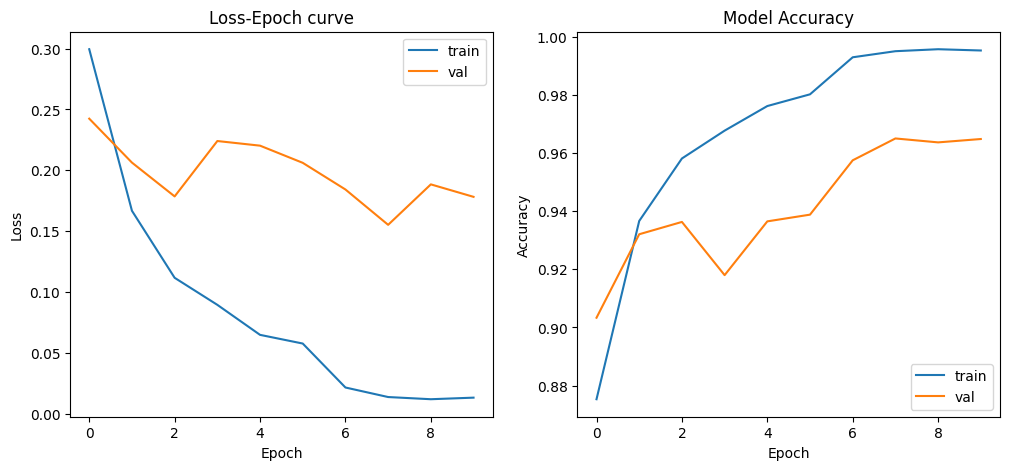

In [34]:
loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)

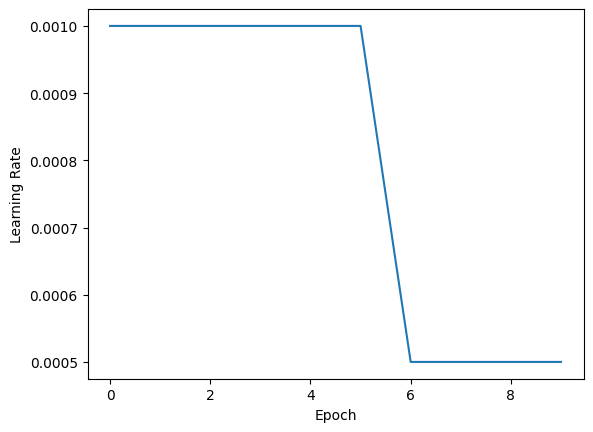

In [35]:
plt.plot(lr_epoch)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

# to .onnx

In [36]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 64.4 MB/s eta 0:00:00


In [37]:
dict_file = os.path.join(model_path, f'{model_name}_{opt_name}.pt')

pretrained = torch.load(dict_file)

state_dict = pretrained['state_dict']
labels = pretrained['label']

model_dict = classifier.state_dict()
model_dict.update(state_dict)
classifier.load_state_dict(model_dict)

<All keys matched successfully>

In [ ]:
classifier = classifier.to(device)
classifier.eval()

In [39]:
labels

['disease', 'normal']

In [40]:
import torch.onnx

In [41]:
torch_input = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(classifier, torch_input, os.path.join(model_path, f'{model_name}_{opt_name}.onnx'))

# Inference

In [42]:
def inference(img_path):

    img = Image.open(img_path)
    img = img.resize((224, 224))
    img = ToTensor()(img).unsqueeze(0).to(device)

    outputs = classifier(img)
    result = outputs.softmax(1)
    # result_dict = {}

    # for i, value in enumerate(result[0].tolist()):
    #     result_dict[labels[i]] = value

    # result = sorted(result_dict.items(), key=lambda x:x[1], reverse=True)

    return (result[0].argmax(), result[0].tolist())

In [43]:
if not os.path.exists('/content/A6_test'):
    os.makedirs('/content/A6_test')

!unzip -qq /content/drive/MyDrive/CV_project/data/SKIN/disease/test/A6_test.zip -d /content/A6_test

In [44]:
root = '/content/A6_test'

In [45]:
predictions = {'target':[], 'pred':[], 'probs':[]}
for folder in os.listdir(root):
    print(folder, len(os.listdir(os.path.join(root, folder))))
    for file in os.listdir(os.path.join(root, folder)):
        predictions['target'].append(folder)
        inf_result = inference(os.path.join(root, folder, file))
        predictions['pred'].append(labels[inf_result[0]])
        predictions['probs'].append(inf_result[1])
        if len(predictions['pred']) % 1000 == 0:
            print(len(predictions['pred']), "done")

normal 1605
1000 done
disease 1514
2000 done
3000 done


In [46]:
import json

with open(f'/content/drive/MyDrive/CV_project/skin_model/prediction/{model_type}_{model_name}_{opt_name}.json', 'w') as f:
    json.dump(predictions, f)

In [47]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

font_files = font_manager.findSystemFonts(fontpaths='/content/drive/MyDrive/Pal-ette/D2Coding')
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rc('font', family='D2Coding')

[Text(0, 0.5, 'disease'), Text(0, 1.5, 'normal')]

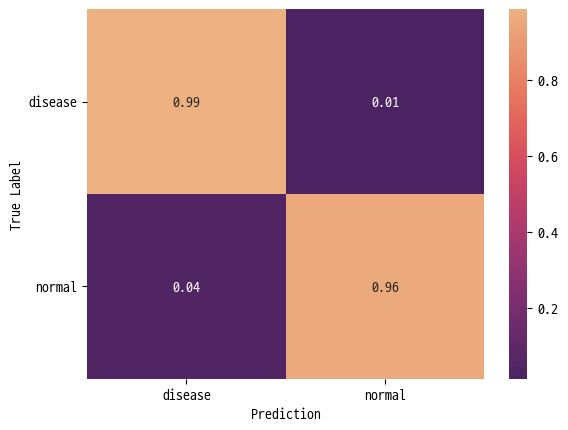

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(predictions['target'], predictions['pred'], normalize='true')
hm = sns.heatmap(cm, annot=True, fmt='.2f', cmap='flare_r')
hm.set_xlabel('Prediction', fontsize=10)
hm.set_ylabel('True Label', fontsize=10)
hm.set_xticklabels(labels=labels, fontsize=10)
hm.set_yticklabels(labels=labels, fontsize=10, rotation=0)

In [49]:
from sklearn.metrics import classification_report

cr = classification_report(predictions['target'], predictions['pred'])
print(cr)

              precision    recall  f1-score   support

     disease       0.96      0.99      0.97      1514
      normal       0.99      0.96      0.97      1605

    accuracy                           0.97      3119
   macro avg       0.97      0.97      0.97      3119
weighted avg       0.97      0.97      0.97      3119



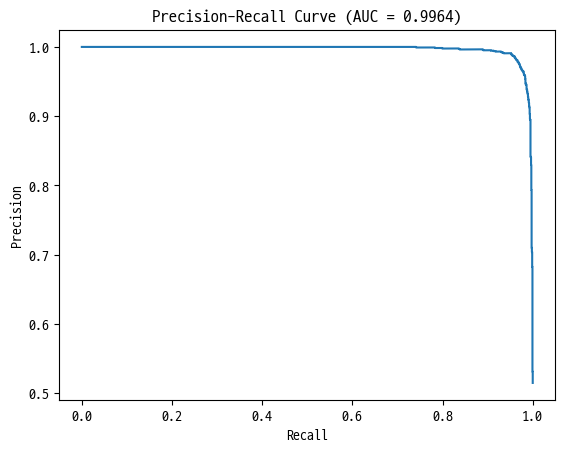

In [50]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import numpy as np

target = np.array(predictions['target'])
probs = np.array(predictions['probs'])[:, 1]

precision, recall, thresholds = precision_recall_curve(target, probs, pos_label='normal')
pr_auc = auc(recall, precision)
plt.plot(recall, precision)
plt.title('Precision-Recall Curve (AUC = ' + str(round(pr_auc,4)) + ')')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()